# Visualizing 10k analysis

This notebook examines the relationships between: _The similarity of a given 10k with the previously filed one_ __and__ _The movement of the stock since the 10k was filed_

## Importing the Necessary Files

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import tqdm.notebook as tqdm

from matplotlib import cm
from yahoofinancials import YahooFinancials
from datetime import timedelta
from nltk.tokenize import treebank

import os
import pickle

In [2]:
cik_tik = pd.read_csv('cos_and_jaccard_stats.csv')
final_ciks = pickle.load(open('final_ciks.p','rb'))
cik_tik.head()

,Unnamed: 0,cik,first_date,last_date,min_cos,max_cos,avg_cos,min_jaccard,max_jaccard,avg_jaccard,ticker
0,0,1090872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a
1,1,1675149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aa
2,2,1420529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aacg
3,3,1802457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aacq
4,4,1209028,2004-03-15,2020-02-24,0.830653,0.918406,0.879454,0.709508,0.849112,0.785378,aaic


In [3]:
tickers = cik_tik.loc[[(value in final_ciks) for value in cik_tik.cik.astype(str)]].set_index('cik')['ticker']
tickers

cik
1209028    aaic
1069183    aaxn
825313       ab
1144980     abg
1800        abt
           ... 
1168054     xec
72903       xel
917225      xpl
1136869     zbh
109380     zion
Name: ticker, Length: 303, dtype: object

## Sentiment Analysis Stuff

NOTE! It is not necessary to run this section again when re-running the notebook and it takes a while to run

...this should be moved to the 10k processing notebook

In [41]:
#lo_mc = pd.read_csv('LoughranMcDonald_MasterDictionary_2018.csv')
neg_words_df = pd.read_excel(open('LoughranMcDonald_SentimentWordLists_2018.xlsx', 'rb'),
              sheet_name='Negative', header = None) 
pos_words_df = pd.read_excel(open('LoughranMcDonald_SentimentWordLists_2018.xlsx', 'rb'),
              sheet_name='Positive', header = None) 

pos_words = set([entry.lower() for entry in list(pos_words_df[0])])
neg_words = set([entry.lower() for entry in list(neg_words_df[0])])

tokenizer = treebank.TreebankWordTokenizer()

In [134]:
def sentiment(document,pos_words = pos_words, neg_words = neg_words):
    '''
    This is a "quick and dirty" sentiment analyzer which
    allows the use of a custom list of positive/negative
    words.
    
    Input
    -----
    A single text document/sentence as a string
    
    Output
    ------
    A sentiment score for the document
    '''
    words = [word.lower() for word in tokenizer.tokenize(document)]
    pos = 0
    neg = 0
    for word in words:
        if word in pos_words:
            pos += 1
        elif word in neg_words:
            neg += 1
    try:
        sent = 0.5 + 0.5*(pos-neg)/(pos+neg)
    except:
        sent = 0.5
    return sent

In [137]:
def score_docs(cik_list):
    '''
    This function goes through all the ciks and
    gets the sentiment score for each document.
    Currently (on ubuntu 18.04) this process maxes
    out a singe cpu core at a time. This is an
    "embarrasingly parallel" situation which could
    run multiple docs at the same time if cython
    was implemented.
    
    Input
    -----
    list of the ciks to process
    
    Output
    ------
    None, the dataframes are saved as csvs
    '''
    for cik in cik_list:
        cik = str(cik)
        scores = []
        merged_texts = pickle.load(open('final_10ks/' + cik + '/' + 'merged_texts.p', 'rb'))
        for doc in merged_texts:
            scores.append(sentiment(doc))
        # scores_df = pd.read_csv('final_10ks/' + cik + '/' + cik + '_sim_scores.csv')
        scores_df = pd.read_csv('data/' + cik + '.csv')
        scores_df['sentiment_score'] = scores
        scores_df.to_csv('final_10ks/' + cik + '/final_scores.csv')
        # print(scores_df)
# score_docs(['1209028'])# test
score_docs(list(tickers.index))

## Downloading the Price Data From Yahoo

In [4]:
for cik in tickers.index[:2]:
    # iterate through the files
    ticker = str(tickers[cik]).upper()
    path = 'final_10ks/' + str(cik) + '/final_scores.csv'
    sim_scores = pd.read_csv(path)
    #print(sim_scores.head())
    prices_df = pd.DataFrame()
    sim_scores.dates = pd.to_datetime(sim_scores.dates)
    for index, date in enumerate(sim_scores.dates):
        # no score for first date
        start_date = str(sim_scores.dates[index])[:10]
        end_date = str(pd.to_datetime(sim_scores.dates)[index]+timedelta(weeks=12))[:10]
        try:
            prices_df = prices_df.append(yf.download(ticker, start = start_date, end = end_date, progress=False))
        except:
            prices_df = yf.download(ticker, start = start_date, end = end_date, progress=False)
    if prices_df.empty == False:
        print('\n' + str(tickers[cik]).upper(), cik, start_date)
        prices_df['dates'] = pd.to_datetime(prices_df.index)
        prices_df = prices_df.merge(sim_scores, how='outer', left_on = 'dates', right_on = 'dates')
        #print(prices_df.head(100))
        prices_df.to_csv('data/'+str(cik)+'_prices.csv')
        # find out how to merge prices_df with the sim_scores dataframe. probably a 
prices_df.head(100)


1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this date range, symbol may be delisted

1 Failed download:
- AAIC: No data found for this dat

,Open,High,Low,Close,Adj Close,Volume,dates,Unnamed: 0,Unnamed: 0.1,cosine_score,jaccard_score,sentiment_score
0,12.8825,13.2450,12.8800,12.9825,12.9825,4610000,2004-03-04,0.0,0.0,NaN,NaN,0.281147
1,12.7875,12.9450,12.0575,12.1500,12.1500,11481600,2004-03-05,NaN,NaN,NaN,NaN,NaN
2,13.1500,14.7850,12.8150,14.2725,14.2725,70558000,2004-03-08,NaN,NaN,NaN,NaN,NaN
3,14.2775,15.0275,13.6500,13.7375,13.7375,39364000,2004-03-09,NaN,NaN,NaN,NaN,NaN
4,13.8775,14.1050,13.2875,13.3475,13.3475,16527200,2004-03-10,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
95,10.5400,10.8300,10.5300,10.6200,10.6200,728600,2006-05-08,NaN,NaN,NaN,NaN,NaN
96,10.5600,10.6400,10.4700,10.5100,10.5100,563300,2006-05-09,NaN,NaN,NaN,NaN,NaN
97,10.6100,10.7000,10.4700,10.5000,10.5000,759600,2006-05-10,NaN,NaN,NaN,NaN,NaN
98,10.5000,10.6000,10.0000,10.1400,10.1400,1225600,2006-05-11,NaN,NaN,NaN,NaN,NaN


In [5]:
list(prices_df[prices_df['cosine_score'] > 0].index)

[59, 117, 175, 234, 292, 350, 408, 466, 524, 582, 640, 699, 758, 817]

In [6]:
prices_df.iloc[59:117,:]

,Open,High,Low,Close,Adj Close,Volume,dates,Unnamed: 0,Unnamed: 0.1,cosine_score,jaccard_score,sentiment_score
59,10.44,10.49,10.10,10.11,10.11,2536900,2006-03-16,1.0,1.0,0.722931,0.556156,0.244545
60,10.06,10.22,10.00,10.00,10.00,1804800,2006-03-17,NaN,NaN,NaN,NaN,NaN
61,10.05,10.34,10.00,10.23,10.23,1813800,2006-03-20,NaN,NaN,NaN,NaN,NaN
62,10.57,10.61,10.30,10.39,10.39,2622900,2006-03-21,NaN,NaN,NaN,NaN,NaN
63,10.32,10.84,10.26,10.70,10.70,2618600,2006-03-22,NaN,NaN,NaN,NaN,NaN
64,11.00,11.24,10.71,10.88,10.88,3423200,2006-03-23,NaN,NaN,NaN,NaN,NaN
65,10.79,11.13,10.70,10.85,10.85,1557100,2006-03-24,NaN,NaN,NaN,NaN,NaN
66,10.86,10.92,10.35,10.76,10.76,1578000,2006-03-27,NaN,NaN,NaN,NaN,NaN
67,10.51,10.75,10.41,10.55,10.55,1581600,2006-03-28,NaN,NaN,NaN,NaN,NaN
68,10.52,10.80,10.52,10.72,10.72,895000,2006-03-29,NaN,NaN,NaN,NaN,NaN


## Reindexing dates so price movements start the day the 10k was filed

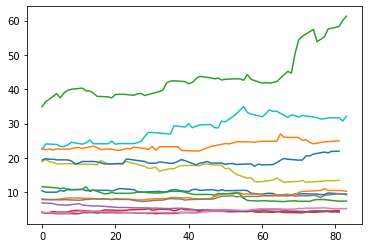

In [7]:
start_dates = list(prices_df[prices_df['cosine_score'] > 0].index)
for i in range(len(start_dates)-1):
    plot_df = prices_df.iloc[start_dates[i]:start_dates[i+1],:]
    time_elapsed = [(date - list(plot_df.dates)[0]).days for date in list(plot_df.dates)]
    opening_prices = list(plot_df.Open.values)
    plt.plot(time_elapsed, opening_prices)

## Rescaling Y to show price movement

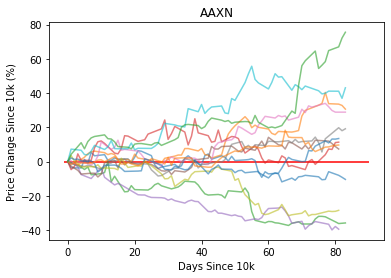

In [8]:
start_dates = list(prices_df[prices_df['cosine_score'] > 0].index)
plt.hlines(0,xmin = -1,xmax = 90, color='red')
plt.title(str(tickers[cik]).upper())
plt.xlabel('Days Since 10k')
plt.ylabel('Price Change Since 10k (%)')
for i in range(len(start_dates)-1):
    plot_df = prices_df.iloc[start_dates[i]:start_dates[i+1],:]
    time_elapsed = [(date - list(plot_df.dates)[0]).days for date in list(plot_df.dates)]
    opening_prices = np.multiply(np.subtract(np.divide(list(plot_df.Open.values),list(plot_df.Open.values)[0]),1),100)
    plt.plot(time_elapsed, opening_prices, alpha=0.6)

## Checking values and visualizing AAXN

In [9]:
stats_df = pd.read_csv('cos_and_jaccard_stats.csv')
stats_df[stats_df.cik == cik].min_cos.values[0]
stats_df[stats_df.cik == cik].max_cos.values[0]

0.9091613625516192

In [10]:
stats_df.sort_values('max_jaccard', ascending = False).max_jaccard.values[0]

0.9869918699186992

In [11]:
stats_df.sort_values('min_jaccard').min_jaccard.values[0]

0.00590493061706525

In [12]:
plot_df = prices_df.iloc[start_dates[i]:start_dates[i+1],:]
plot_df.cosine_score.sum()

0.8646399935061488

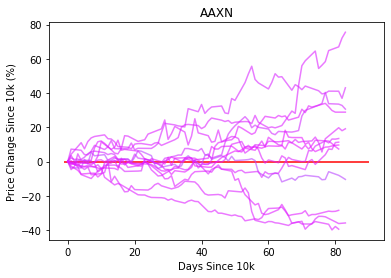

In [13]:
cmap = cm.get_cmap('cool')

start_dates = list(prices_df[prices_df['cosine_score'] > 0].index)
plt.hlines(0,xmin = -1,xmax = 90, color='red')
plt.title(str(tickers[cik]).upper())
plt.xlabel('Days Since 10k')
plt.ylabel('Price Change Since 10k (%)')
for i in range(len(start_dates)-1):
    plot_df = prices_df.iloc[start_dates[i]:start_dates[i+1],:]
    time_elapsed = [(date - list(plot_df.dates)[0]).days for date in list(plot_df.dates)]
    opening_prices = np.multiply(np.subtract(np.divide(list(plot_df.Open.values),list(plot_df.Open.values)[0]),1),100)
    plt.plot(time_elapsed, opening_prices, alpha=0.6, color = cmap(plot_df.cosine_score.sum()))

## Replotting with color coding

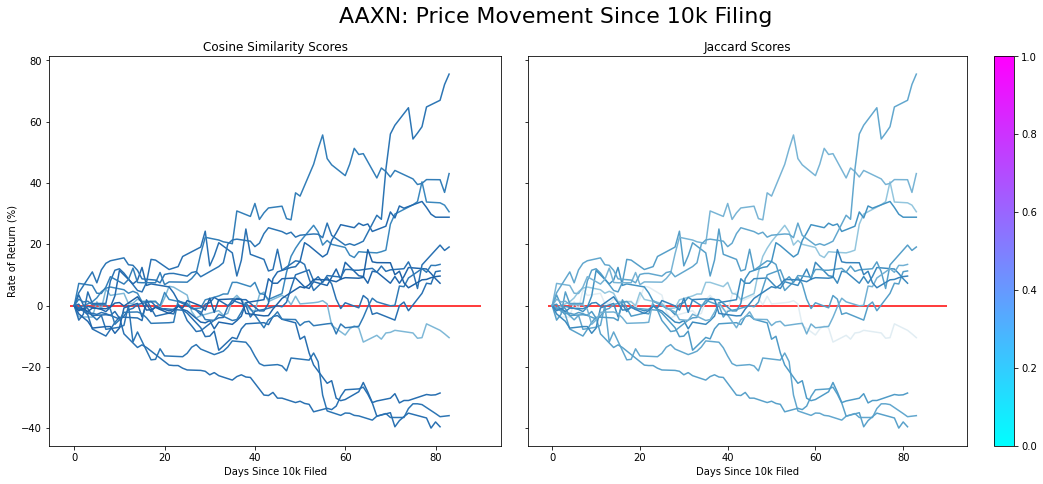

In [18]:
## Look at: https://stackoverflow.com/questions/4805048/how-to-get-different-colored-lines-for-different-plots-in-a-single-figure
## ^^the fancylegend is a dope option

gs_kw = dict(width_ratios=[7, 8.5], height_ratios=[7])

cmap2 = sns.color_palette("RdBu", as_cmap=True)
start_dates = list(prices_df[prices_df['cosine_score'] > 0].index)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw=gs_kw)
f.set_figheight(6)
f.set_figwidth(15)
f.tight_layout()
plt.suptitle(str(tickers[cik]).upper() + ': Price Movement Since 10k Filing',
             y=1.08,
             fontsize = 22)

## Plot 1
ax1.title.set_text('Cosine Similarity Scores')
plt.setp(ax1, ylabel='Rate of Return (%)')
plt.setp(ax1, xlabel='Days Since 10k Filed')
ax1.hlines(0,xmin = -1,xmax = 90, color='red')
cos_scores = []
for i in range(len(start_dates)-1):
    plot_df = prices_df.iloc[start_dates[i]:start_dates[i+1],:]
    cos_scores.append(plot_df.cosine_score.sum())
    time_elapsed = [(date - list(plot_df.dates)[0]).days for date in list(plot_df.dates)]
    opening_prices = np.multiply(np.subtract(np.divide(list(plot_df.Open.values),list(plot_df.Open.values)[0]),1),100)
    ax1.plot(time_elapsed, opening_prices)
colors = [cmap2(i) for i in cos_scores]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])

## Plot 2
ax2.title.set_text('Jaccard Scores')
plt.setp(ax2, xlabel='Days Since 10k Filed')
f.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax2)
ax2.hlines(0,xmin = -1,xmax = 90, color='red')
jaccard_scores = []
for i in range(len(start_dates)-1):
    plot_df = prices_df.iloc[start_dates[i]:start_dates[i+1],:]
    jaccard_scores.append(plot_df.jaccard_score.sum())
    time_elapsed = [(date - list(plot_df.dates)[0]).days for date in list(plot_df.dates)]
    opening_prices = np.multiply(np.subtract(np.divide(list(plot_df.Open.values),list(plot_df.Open.values)[0]),1),100)
    ax2.plot(time_elapsed, opening_prices)
colors = [cmap2(i) for i in jaccard_scores]
for i,j in enumerate(ax2.lines):
    j.set_color(colors[i])

In [ ]:
for cik in tickers.index[:2]:
    # iterate through the files
    ticker = str(tickers[cik]).upper()
    path = 'data/' + str(cik) + '.csv'
    sim_scores = pd.read_csv(path)
    #print(sim_scores.head())
    prices_df = pd.DataFrame()
    sim_scores.dates = pd.to_datetime(sim_scores.dates)
    for index, date in enumerate(sim_scores.dates):
        # no score for first date
        start_date = str(sim_scores.dates[index])[:10]
        end_date = str(pd.to_datetime(sim_scores.dates)[index]+timedelta(weeks=12))[:10]
        try:
            prices_df = prices_df.append(yf.download(ticker, start = start_date, end = end_date, progress=False))
        except:
            prices_df = yf.download(ticker, start = start_date, end = end_date, progress=False)
    if prices_df.empty == False:
        print('\n' + str(tickers[cik]).upper(), cik, start_date)
        prices_df['dates'] = pd.to_datetime(prices_df.index)
        prices_df = prices_df.merge(sim_scores, how='outer', left_on = 'dates', right_on = 'dates')
        #print(prices_df.head(100))
        prices_df.to_csv('data/'+str(cik)+'_prices.csv')
        # find out how to merge prices_df with the sim_scores dataframe. probably a 
prices_df.head(100)

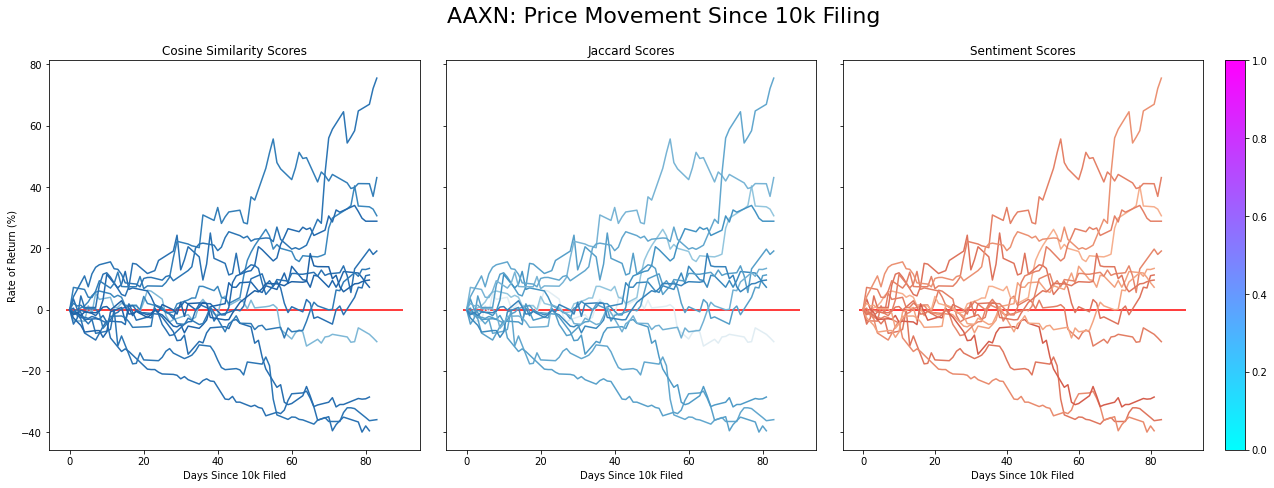

In [42]:
cmap2 = sns.color_palette("RdBu", as_cmap=True)
start_dates = list(prices_df[prices_df['cosine_score'] > 0].index)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                             sharey=True,
                             gridspec_kw={'width_ratios':[7,7,8.5],
                                          'height_ratios':[7]}
                            )

f.set_figheight(6)
f.set_figwidth(18)
f.tight_layout()
plt.suptitle(str(tickers[cik]).upper() + ': Price Movement Since 10k Filing',
             y=1.09,
             fontsize = 22)

## Plot 1
ax1.title.set_text('Cosine Similarity Scores')
plt.setp(ax1, ylabel='Rate of Return (%)')
plt.setp(ax1, xlabel='Days Since 10k Filed')
ax1.hlines(0,xmin = -1,xmax = 90, color='red')
cos_scores = []
for i in range(len(start_dates)-1):
    plot_df = prices_df.iloc[start_dates[i]:start_dates[i+1],:]
    cos_scores.append(plot_df.cosine_score.sum())
    time_elapsed = [(date - list(plot_df.dates)[0]).days for date in list(plot_df.dates)]
    opening_prices = np.multiply(np.subtract(np.divide(list(plot_df.Open.values),list(plot_df.Open.values)[0]),1),100)
    ax1.plot(time_elapsed, opening_prices)
colors = [cmap2(i)[:3] for i in cos_scores]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])

## Plot 2
ax2.title.set_text('Jaccard Scores')
plt.setp(ax2, xlabel='Days Since 10k Filed')
ax2.hlines(0,xmin = -1,xmax = 90, color='red')
jaccard_scores = []
for i in range(len(start_dates)-1):
    plot_df = prices_df.iloc[start_dates[i]:start_dates[i+1],:]
    jaccard_scores.append(plot_df.jaccard_score.sum())
    time_elapsed = [(date - list(plot_df.dates)[0]).days for date in list(plot_df.dates)]
    opening_prices = np.multiply(np.subtract(np.divide(list(plot_df.Open.values),list(plot_df.Open.values)[0]),1),100)
    ax2.plot(time_elapsed, opening_prices)
colors = [cmap2(i)[:3] for i in jaccard_scores]
for i,j in enumerate(ax2.lines):
    j.set_color(colors[i])
    
## Plot 3
ax3.title.set_text('Sentiment Scores')
plt.setp(ax3, xlabel='Days Since 10k Filed')
f.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax3)
ax3.hlines(0,xmin = -1,xmax = 90, color='red')
sentiment_scores = []
for i in range(len(start_dates)-1):
    plot_df = prices_df.iloc[start_dates[i]:start_dates[i+1],:]
    sentiment_scores.append(plot_df.sentiment_score.sum())
    time_elapsed = [(date - list(plot_df.dates)[0]).days for date in list(plot_df.dates)]
    opening_prices = np.multiply(np.subtract(np.divide(list(plot_df.Open.values),list(plot_df.Open.values)[0]),1),100)
    ax3.plot(time_elapsed, opening_prices)
colors = [cmap2(i)[:3] for i in sentiment_scores]
for i,j in enumerate(ax3.lines):
    j.set_color(colors[i])